In [ ]:
! python -m pip install pyaudio

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import IPython
import string
import math
import scipy.signal as sgn

import pyaudio
import wave

from helpers import *

In [2]:
# CONSTANTS

Fs = 16000 # sampling freqency
T=.6 # transmission time per symbol
TWOPI = 2 * np.pi

min_freq = 1000
max_freq = 2000

tolerance = 8 # the max ratio between the loudest and the less loud freqencies recieved

# Emitter + Reciever initial noise range detection

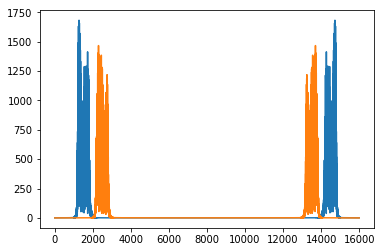

2

In [3]:
# Record initial noise !!

CHUNKSIZE = int(2*Fs) # 2 time slots

# initialize portaudio
p = pyaudio.PyAudio()
stream = p.open(format=pyaudio.paInt16, channels=1, rate=Fs, input=True, frames_per_buffer=CHUNKSIZE)

# do this as long as you want fresh samples
data1 = stream.read(CHUNKSIZE)
numpydata = np.fromstring(data1, dtype=np.int16)

noise = numpydata/1 # need to change the amplitude ??

# close stream
stream.stop_stream()
stream.close()
p.terminate()

# Check presence of silence between 1kHz and 2kHz
noise12 = butter_bandpass_filter(noise, 1200, 1800, Fs, order=10)
amplitude12 = np.mean(abs(noise12))

# Check presence of silence between 2kHz and 3kHz
noise23 = butter_bandpass_filter(noise, 2200, 2800, Fs, order=10)
amplitude23 = np.mean(abs(noise23))

# Plot
plt.plot(abs(np.fft.fft(noise12, Fs)))
plt.plot(abs(np.fft.fft(noise23, Fs)))
plt.show()

NOISE_RANGE=0 
if (abs(amplitude12) < abs(amplitude23)):
    NOISE_RANGE=1
else:
    NOISE_RANGE=2

if(NOISE_RANGE==2):
    freq_shift=1000
else:
    freq_shift=0
    
NOISE_RANGE # =1 if channel is free between 1kHz and 2kHz, =2 if 2kHz to 3kHz

# Pulse

WARNING : on utilise my_base entre les index 1 et 7 compris (les index 0 et 8 sont inutilisés !!!)

In [4]:
my_alphabet = ['ü'] + list(string.printable) #our alphabet

#transforms a character from our alphabet to its binary representation
def toBinary(c):
    my_index = my_alphabet.index(c)
    toBinary = bin(my_index)
    return toBinary[2:] # we remove the header "0b"

In [5]:
toBinary("a")

'1011'

In [6]:
number_bits = int(math.ceil(np.log2(len(my_alphabet)))) # the number of bits we require to represent our alphabet
my_base = np.linspace(min_freq, max_freq, num = math.ceil(number_bits+2)) # +2 because we dont need the borders (1000 and 2000)
#ON DOIT BIEN AUSSI SHIFTER LE LIN SPACE DANS CE CAS NON ??

base_distance = my_base[1] - my_base[0] # distance between 2 waves freqs

In [7]:
my_base

array([ 1000.,  1125.,  1250.,  1375.,  1500.,  1625.,  1750.,  1875.,
        2000.])

In [8]:
#adds to x a wave of frequency f
def wave(f,n):
    x = np.sin(TWOPI * (float(f + freq_shift)/Fs) * n) # If freq_shift=1000, all sines are shifted to the 1kHz-2kHz range.
    return x

#transforms a character from our alphabet to a distinct wave
def toWave(c):
    my_bin = toBinary(c)
    x = np.zeros(int(T * Fs))
    n = np.arange(len(x))
    for i in range(len(my_bin) -1, -1, -1):
        if(int(my_bin[i])):
            f = my_base[len(my_bin) - 1] # because of the binary base
            x += wave(f, n)
    return x

In [9]:
def toWave2(c) :
    my_bin = toBinary(c)
    raised = np.zeros(int(T * Fs))
    for i in range(len(my_bin) -1, -1, -1):
        if(int(my_bin[i])):    
            f = my_base[len(my_bin) - i] # because of the binary base
            raised += raised_cosine(f + freq_shift, T, Fs, roll_off=0.5)
    return raised

In [10]:
toBinary("G")

'101011'

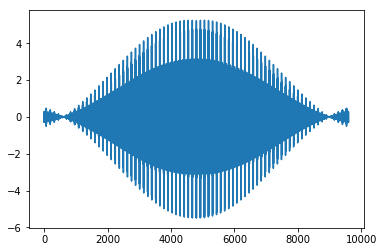

In [11]:
#You can test every character here (example with 'D')

# x = toWave('A')
x = toWave2('G')
# the plot
plt.plot(x)
plt.show()

# we can play it:
IPython.display.Audio(x, rate=Fs)

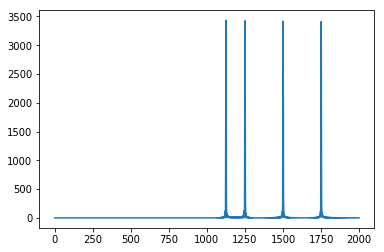

In [12]:
X = np.fft.fft(x, Fs)
plt.plot(np.abs(X)[1000:3000])
plt.show()

NOTABENE : LES FREQUENCES VONT EN DECROISSANT

# Emitter

In [13]:
# open the message file
my_text = open('message.txt', 'r')
my_message = my_text.read()
my_text.close

<function TextIOWrapper.close>

In [14]:
# array of our waves
my_message_waves = []
for i in range(len(my_message)):
    # my_message_waves.append(toWave(my_message[i]))
    my_message_waves.append(toWave2(my_message[i]))

In [15]:
# Generate inital clap !!!
clap = np.random.normal(0, 3, size=2000)
z = np.zeros(Fs-2000)
## INITIAL_SILENCE = np.zeros(4*Fs)
clap = np.concatenate(( clap, z))

In [16]:
# we generate the wave to be sent
to_be_sent = []
to_be_sent = np.concatenate((to_be_sent, clap)) # add initial clap

for i in range(0, len(my_message_waves)):
    to_be_sent = np.concatenate((to_be_sent, my_message_waves[i]))

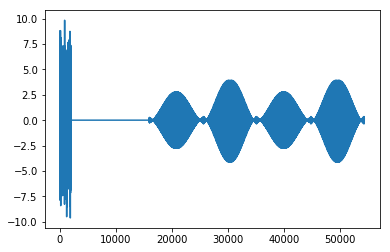

In [17]:
plt.plot(to_be_sent)
plt.show()

# we can play it:
IPython.display.Audio(to_be_sent, rate=Fs)

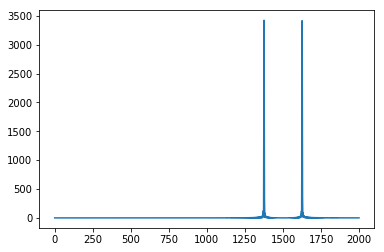

In [18]:
plt.plot(abs(np.fft.fft(to_be_sent[int(Fs):int(Fs+T*Fs)], Fs))[1000:3000])

# Reciever's audio recorder and chunker

In [32]:
# Record full stream at once.
CHUNKSIZE = int(20*T*Fs) # length of 10 symbols
SYMBOLSIZE = int(T*Fs)

# initialize portaudio
p = pyaudio.PyAudio()
stream = p.open(format=pyaudio.paInt16, channels=1, rate=Fs, input=True, frames_per_buffer=CHUNKSIZE)

data = stream.read(CHUNKSIZE)
stream.stop_stream()
stream.close()
p.terminate()

In [33]:
full_transmission = np.fromstring(data, dtype=np.int16)
filtered_transmission = butter_bandpass_filter(full_transmission[8000:], 900+freq_shift, 2000+freq_shift, Fs, order=7) # 8000 for not hearing the initial touch press pop

# filtered_transmission = full_transmission

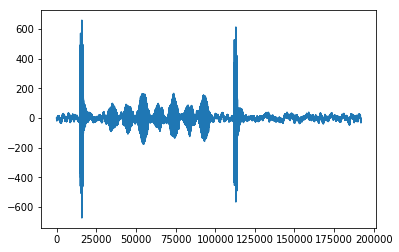

In [34]:
plt.plot(full_transmission)
IPython.display.Audio(full_transmission, rate=Fs)

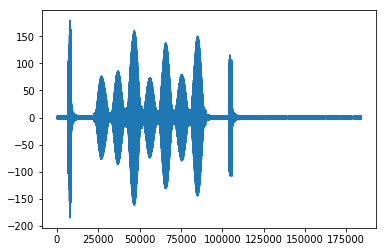

In [35]:
plt.plot(filtered_transmission)
IPython.display.Audio(filtered_transmission, rate=Fs)

In [36]:
begin = 0
max_t = np.max(filtered_transmission[:int(3*T*Fs)])
tresh = 1/2*max_t

for i in range(0, len(filtered_transmission)):
    if(np.mean(filtered_transmission[i:i+100]>tresh)):
        begin = i
        break
        
filtered_transmission = filtered_transmission[begin+Fs:] # We begin to use the signal after the clap only

end = 0

for i in range(0, len(filtered_transmission)):
    if(np.mean(filtered_transmission[len(filtered_transmission)-(i+100):len(filtered_transmission)-i]>tresh)):
        end = len(filtered_transmission)-i
        break
        
filtered_transmission = filtered_transmission[:end-Fs] 

In [37]:
end-Fs

67144

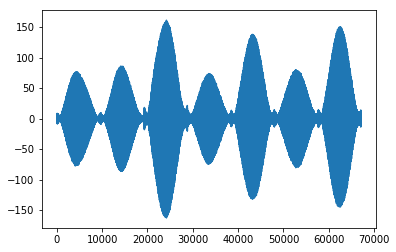

In [38]:
plt.plot(filtered_transmission)
IPython.display.Audio(filtered_transmission, rate=Fs)

In [39]:
len(filtered_transmission)

67144

In [40]:
def chunker(l, n):
    for i in range(0, len(l), n):
        yield l[i:i+n]

In [41]:
filter_symbol = list(chunker(filtered_transmission, int(SYMBOLSIZE))) 
len(filter_symbol[0])

9600

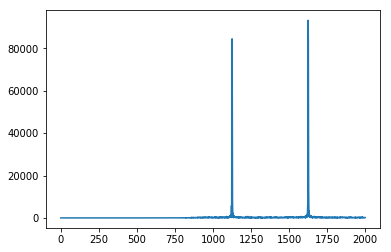

In [42]:
plt.plot(abs(np.fft.fft(filter_symbol[0], Fs))[1000:3000])
IPython.display.Audio(filter_symbol[0], rate=Fs)

In [43]:
decoded = []

for raw_symbol in filter_symbol :
    
    filtered_symbol = [] # laisser l'order très bas (1 ou 2) sinon ça marche plus   
    for i in range (1, 8):
        filtered_symbol.append(butter_bandpass_filter(raw_symbol, my_base[i]+freq_shift-base_distance/2, my_base[i]+freq_shift+base_distance/2, Fs, order=1))
        #filtered_symbol.append(raw_symbol)
    
    # freqs we wanna check if present or not in the sent wave
    freq_cosine = []
    for i in range (1, 8):
        freq_cosine.append(raised_cosine(my_base[i]+freq_shift, T, Fs, roll_off=0.5))

    # x-corr to see if present in the signal
    correlated_symbol = []
    for i in range (0, 7):
        correlated_symbol.append(sgn.correlate(filtered_symbol[i], freq_cosine[i], mode='same'))
    
    # Compute the average amplitude of the corss-correlation (of high, the freq is present, else it is not)
    amplitude_symbol = []
    for i in range (0, 7):
        amplitude_symbol.append(np.mean(abs(correlated_symbol[i])))
    
    # Compute the max and the min of the amplitudes (of the amps are nearer to the max amp we say that the freq was sent, else not)
    max_amp = np.max(amplitude_symbol)
    min_amp = np.min(amplitude_symbol)

    # Finally tell if freq present (1) or not (0)
    decoded_symbol = []
    for i in range (0, 7):
        decoded_symbol.append(1 if abs(amplitude_symbol[i] - max_amp) < tolerance*abs(amplitude_symbol[i] - min_amp) else 0)
        
    decoded.append(list(reversed(decoded_symbol)))

decoded

[[0, 0, 1, 0, 0, 0, 1],
 [0, 0, 1, 0, 0, 0, 1],
 [1, 0, 1, 1, 1, 0, 1],
 [0, 0, 1, 0, 1, 1, 0],
 [0, 0, 1, 1, 1, 1, 1],
 [0, 0, 1, 0, 1, 1, 0],
 [0, 0, 1, 1, 1, 1, 1]]

In [44]:
final_index = []
for binary in decoded :
    s = ''
    for bit in binary :
        s += str(bit)
    final_index.append(int(s, 2))
    
final_index

final_message = ''
for index in final_index :
    if index < 103 : #On devrait pas avoir à verifier ça normalement mais parfois on a des chiffres trop grands
        final_message += my_alphabet[index]
final_message

'gg}lulu'

# Toy colored white noise

In [ ]:
no = np.random.rand(500000)

nono1 = butter_bandpass_filter(no, 120, 900, Fs, order=7)
nono2 = butter_bandpass_filter(no, 2200, 7900, Fs, order=10)

fifi = nono1 + nono2

plt.plot(abs(np.fft.fft(fifi, Fs))[0:8000])

In [ ]:
IPython.display.Audio(fifi, rate=Fs)